In [93]:
from functools import reduce
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
from skimage.color import grey2rgb
from sklearn.cluster import KMeans
import ffmpeg
import json
import matplotlib as mpl
import numpy as np
import os
import scipy.stats
import skimage
import skimage.color
import skimage.draw
import skimage.io
import sklearn.utils
import subprocess
import warnings
from matplotlib import cm


mpl.rcParams['figure.dpi'] = 80
warnings.simplefilter('ignore')

with open(os.path.join('../calibration/depthmap_distance_params.json')) as f:
    depthmap_distance_params = json.load(f)

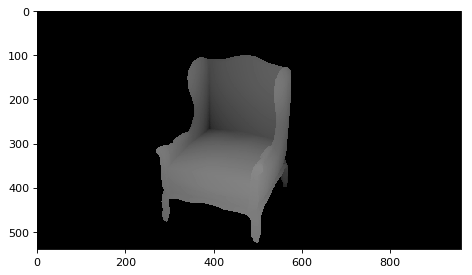

In [53]:
in_filename = '../render/ed1f93956a9d4ce4bb0076f17fab4b46/depth/0000.png'
#in_filename = 'depth.png'
depth = skimage.io.imread(in_filename, as_grey=True)
skimage.io.imshow(depth)

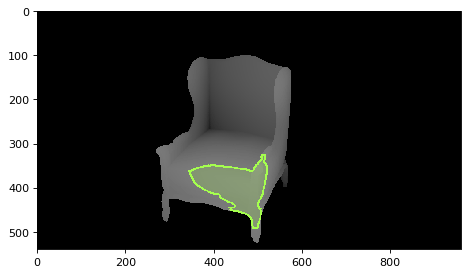

In [62]:
def hex_color(r_hex, g_hex, b_hex, a_float=1.):
    return np.append(np.array([r_hex, g_hex, b_hex]) / 255., a_float)


CONTOUR_COLOR = hex_color(0xa5, 0xff, 0x4e)
MASK_COLOR = np.append(CONTOUR_COLOR[:-1], 0.2)


def composite(im1, im2):
    # See https://en.wikipedia.org/wiki/Alpha_compositing
    alpha1 = np.tile(im1[:,:,-1:], (1, 1, 3))
    alpha2 = np.tile(im2[:,:,-1:], (1, 1, 3))
    color1 = im1[:,:,:-1]
    color2 = im2[:,:,:-1]
    alpha_out = alpha2 + alpha1 * (1 - alpha2)
    color_out = (color2 * alpha2 + color1 * alpha1 * (1 - alpha2)) * (1 / alpha_out)
    return np.dstack((color_out, alpha_out[:,:,0]))


def depthvalue_to_distance(y, max_dist=12.5, inf_value=10000):
    params = depthmap_distance_params
    #y = y - ((y < 0.1) * 100)
    a = params['x0']
    b = params['x1']
    dist = a - (y * b) ** 2
    
    #dist = dist + (dist < -3.5) * -1000 + (dist > 12.5) * 1000
    #dist = dist + (dist > 12.5) * 1000
    dist[dist > max_dist] = inf_value
    return dist

def get_mask(dist):
    return (dist > 0.) * 1.

def thicken(mask, radius=5):
    kernel = np.zeros([radius*2]*2)
    kernel[skimage.draw.circle(*[radius]*3)] = 1.
    return ndimage.convolve(mask, kernel) / kernel.sum()
    
def trace_contour(mask, radius=5):
    thickened = thicken(mask, radius)
    return ((thickened - mask) > 0.) * 1.

def convert_stencil_to_rgb(stencil, color):
    return np.tile(stencil[:,:,np.newaxis], (1, 1, 4)) * color

def combine_layers(depth, mask, contour):
    return reduce(composite, [
        grey2rgb(depth, 1.),
        convert_stencil_to_rgb(1 - mask, MASK_COLOR),
        convert_stencil_to_rgb(contour, CONTOUR_COLOR),
    ])

def render(depth, threshold, radius=5):
    dist = depthvalue_to_distance(depth)
    mask = get_mask(dist - threshold)
    contour = trace_contour(mask, radius)
    return combine_layers(depth, mask, contour)

def to_raw(a):
    return np.uint8(a * 255).tostring(order='F')


rendered = render(depth, 9.8)
skimage.io.imshow(rendered)

9.120880196587713
12.416546900408314
-0.046153217529170315 -0.021983215284873278 0.07984141414532187
0.06749435044327895 0.056697557316482405 0.13505895210908467


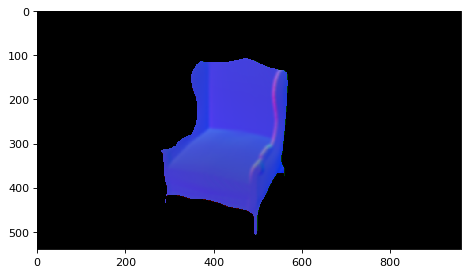

In [204]:
def gkern(kernlen=15, nsig=3):
    """Returns a 2D Gaussian kernel array.
    
    See https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
    """

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(scipy.stats.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def normalize(image):
    min_ = np.nanmin(image)
    max_ = np.nanmax(image)
    normalized = (image - min_) / (max_ - min_)
    return normalized

def get_gradient(dist, radius=5):
    # TODO: switch to np.gradient.
    x_kernel = np.array([-0.5, 0.5]).reshape((1, 2))
    y_kernel = np.transpose(x_kernel)

    x = np.linspace(-1, 1, dist.shape[1])
    y = np.linspace(-1, 1, dist.shape[0])
    xv, yv = np.meshgrid(x, y)
    
    grad_x = ndimage.convolve(dist, x_kernel)
    grad_y = ndimage.convolve(dist, y_kernel)
    grad_x = ndimage.convolve(grad_x, gkern())
    grad_y = ndimage.convolve(grad_y, gkern())
    grad_z = np.sqrt(grad_x ** 2 + grad_y ** 2)
    grad_z = -(grad_x * xv + grad_y * yv) * 1 + (dist
    print(np.nanmin(grad_x), np.nanmin(grad_y), np.nanmin(grad_z))
    print(np.nanmax(grad_x), np.nanmax(grad_y), np.nanmax(grad_z))
    grad = np.dstack((grad_x, grad_y, grad_z))
    grad = normalize(grad)
    return grad


dist = depthvalue_to_distance(depth, inf_value=np.nan)
grad = get_gradient(dist)
grad = np.nan_to_num(grad)
skimage.io.imshow(grad)

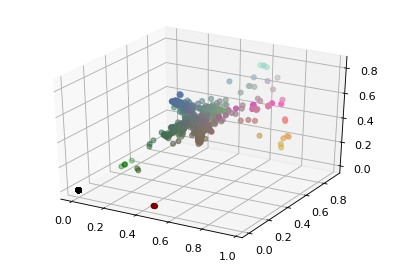

In [197]:
w, h, d = tuple(grad.shape)
colors = np.reshape(grad, (w * h, d))

sample = sklearn.utils.shuffle(colors)[:10000]
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample[:,0], sample[:,1], sample[:,2], color=sample)

#ax = fig.add_subplot(111)
#ax.scatter(sample[:,0], sample[:,1], color=sample)

plt.show()

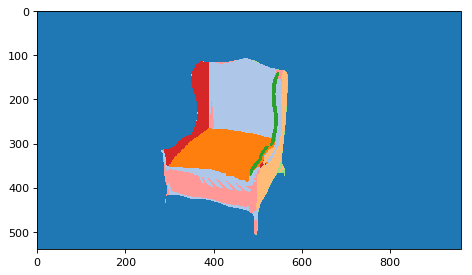

In [198]:
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(colors)
labels = kmeans.predict(colors)
#labels = np.array(labels)
#recolored = labels.reshape((w, h))
#recolored = normalize(recolored)


#codebook = np.random.rand(n_clusters, 3)
codebook = np.array([list(cm.tab20(i/20))[:-1] for i in range(n_clusters)])


def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

recolored = recreate_image(codebook, labels, w, h)

skimage.io.imshow(recolored)

#skimage.io.imshow(labels)


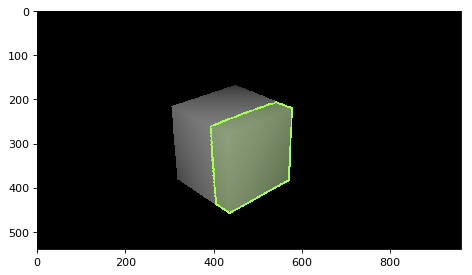

In [51]:
x = np.linspace(-1, 1, dist.shape[1])[np.newaxis,:]
y = np.linspace(-1, 1, dist.shape[0])[:,np.newaxis]

plane = np.array([-5, -1.2, -10.57])

dist = depthvalue_to_distance(depth)
xformed = dist + np.array((x, y, 1)).dot(plane)
mask = get_mask(xformed)

contour = trace_contour(mask)
rendered = combine_layers(depth, mask, contour)
skimage.io.imshow(rendered)

In [ ]:
x = np.linspace(-1, 1, image.shape[1])[np.newaxis,:]
y = np.linspace(-1, 1, image.shape[0])[:,np.newaxis]


frames = []
for t in np.arange(12.3, 16, 1):
    mask = get_mask(image + x * 0.5 + y*0.1 - 0.11, t)
    #mask = get_mask(image, t)
    contour = trace_contour(mask)
    frame = draw_overlay(image, contour)
    frames.append(frame)
    break
    
io.imshow(frames[0])
frames += reversed(frames)
#frames += frames

In [ ]:
data = b''
for frame in frames:
    data += to_raw(np.transpose(frame[:,:,:-1]))
with open('out.raw', 'wb') as f:
    f.write(data)

    
cmd = (ffmpeg
    .input('pipe:', format='rawvideo', pix_fmt='rgb24', video_size=list(reversed(image.shape)))
    .output('out.mp4', pix_fmt='yuv420p')
    .overwrite_output()
    .compile()
)
p = subprocess.Popen(cmd, stdin=subprocess.PIPE)

p.communicate(input=data)
if p.returncode != 0:
    print('Ruhroh')

print('done')

In [ ]:
np.array([0xa5, 0xff, 0xe7]) / 255.

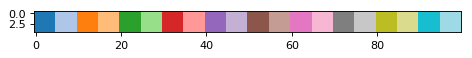

In [178]:
def show_colormap(colormap, res=200):
    get_color = lambda i: list(colormap(i))
    colors = np.array(list(map(get_color, np.linspace(0, 1, res))))
    colors = colors[np.newaxis,:,:]
    colors = np.tile(colors, (int(res / 20), 1, 1))
    skimage.io.imshow(colors)

show_colormap(cm.tab20, 100)